# Imports

In [ ]:
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

from PIL import Image
import cv2

# Set Random Seeds

In [ ]:
import random
random.seed(7)

np.random.seed(7)

tf.random.set_seed(7)

# Create Patches

In [ ]:
with open('/content/drive/My Drive/thesis/naip_chm_mask_3d.pkl', 'rb') as f:
    naip_chm_mask_3d = pickle.load(f)

In [ ]:
# Load the image
naip_natural_tiff = Image.open('/content/drive/MyDrive/thesis/training_images/naip_natural_.tif')

# Convert the image to an array
naip_natural_array = np.array(naip_natural_tiff)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (118901250 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
def split_into_patches(image, patch_size=256, stride=256):
    """
    Splits the image and mask into smaller patches of size patch_size x patch_size,
    with a given stride.

    Args:
        image (numpy.ndarray): The large image array.
        mask (numpy.ndarray): The corresponding mask array.
        patch_size (int): The size of each patch (default is 256).
        stride (int): The stride with which to slide the window across the image (default is 256).

    Returns:
        A list of image patches and a list of corresponding mask patches.
    """
    img_patches = []

    i_max = image.shape[0] - patch_size + 1
    j_max = image.shape[1] - patch_size + 1

    for i in range(0, i_max, stride):
        for j in range(0, j_max, stride):
            img_patch = image[i:i+patch_size, j:j+patch_size]

            img_patches.append(img_patch)

    return np.array(img_patches)

patch_size = 256  # adjust this as needed
stride = 256  # this helps create more data

binary_mask = np.where(naip_chm_mask_3d, 255, 0)[..., 0:1] > 0

img_patches = split_into_patches(naip_natural_array, patch_size, stride)
mask_patches = split_into_patches(binary_mask, patch_size, stride)

print(f"Generated {len(img_patches)} patches.")

Generated 1763 patches.


In [ ]:
# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(img_patches, mask_patches, test_size=0.3, random_state=7)

In [ ]:
img_patches = []
for x in X_train:
    naip_patch = split_into_patches(x, patch_size=256, stride=64)
    img_patches.extend(naip_patch)

mask_patches = []
for y in y_train:
    mask_patch = split_into_patches(y, patch_size=256, stride=64)
    mask_patches.extend(mask_patch)

In [ ]:
## remove patches with too many no data pixels

def filter_patches(img_patches, mask_patches, no_data_value, threshold=0.2):
    """Filter out patches with more than a certain percentage of 'no data' pixels."""
    valid_patch_indices = []
    for i, img_patch in enumerate(img_patches):
        no_data_pixels = np.sum(img_patch == no_data_value)
        if no_data_pixels / img_patch.size < threshold:
            valid_patch_indices.append(i)

    filtered_img_patches = np.array([img_patches[i] for i in valid_patch_indices])
    filtered_mask_patches = np.array([mask_patches[i] for i in valid_patch_indices])

    return filtered_img_patches, filtered_mask_patches

no_data_value = 0
img_patches, mask_patches = filter_patches(img_patches, mask_patches, no_data_value)

# Define U-Net Model

In [ ]:
def unet2(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    # Downsample
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Train U-Net Model

In [ ]:
# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(img_patches, mask_patches, test_size=0.2, random_state=7)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 693, Validation samples: 174


In [ ]:
model = unet2(input_size=(patch_size, patch_size, 3))  # Adjust the input size if needed

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('model-unet.h5', verbose=1, save_best_only=True)
]

results = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
22/22 [==============================] - ETA: 0s - loss: 3.3956 - accuracy: 0.7822
Epoch 1: val_loss improved from inf to 0.58565, saving model to model-unet.h5
22/22 [==============================] - 37s 657ms/step - loss: 3.3956 - accuracy: 0.7822 - val_loss: 0.5856 - val_accuracy: 0.8282
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.8065
Epoch 2: val_loss improved from 0.58565 to 0.38270, saving model to model-unet.h5
22/22 [==============================] - 4s 162ms/step - loss: 0.6603 - accuracy: 0.8065 - val_loss: 0.3827 - val_accuracy: 0.8078
Epoch 3/25
22/22 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.8196
Epoch 3: val_loss did not improve from 0.38270
22/22 [==============================] - 3s 158ms/step - loss: 0.4264 - accuracy: 0.8196 - val_loss: 0.3840 - val_accuracy: 0.8039
Epoch 4/25
22/22 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8283
Epoch 4: val_loss did not improve from 0.38270
22/22 [==============================] - 3s 157ms/step - loss: 0.3452 - accuracy: 0.8283 - val_loss: 0.4032 - val_accuracy: 0.8038
Epoch 5/25
22/22 [==============================] - ETA: 0s - loss: 0.3106 - accuracy: 0.8335
Epoch 5: val_loss improved from 0.38270 to 0.33442, saving model t

#Evaluate U-Net Model

17/17 [==============================] - 2s 128ms/step


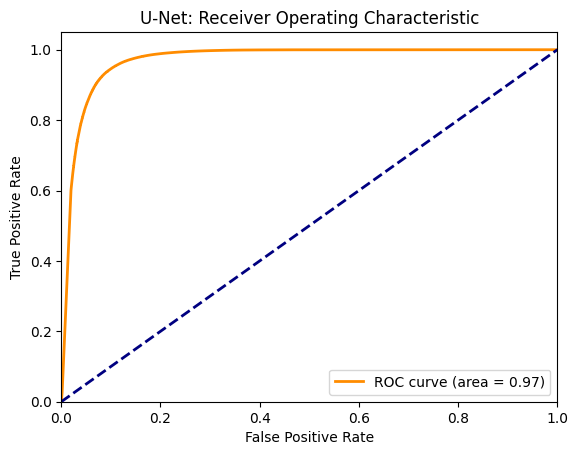

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
# predict on testing set
y_probs = model.predict(X_test)

# calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test.flatten(), y_probs.flatten())
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('U-Net: Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Method 1: Youden’s J statistic
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

# Method 2: Minimizing the Euclidean distance to the top-left corner
distance = np.sqrt((1-tpr)**2 + fpr**2)
optimal_idx_distance = np.argmin(distance)
optimal_threshold_distance = thresholds[optimal_idx_distance]

print(f'Optimal threshold by Youden’s J: {optimal_threshold}')
print(f'Optimal threshold by Euclidean Distance: {optimal_threshold_distance}')

Optimal threshold by Youden’s J: 0.1821703165769577
Optimal threshold by Euclidean Distance: 0.2270093411207199


In [ ]:
print(classification_report(y_test.flatten(), y_probs.flatten()>optimal_threshold_distance))

              precision    recall  f1-score   support

       False       0.99      0.91      0.95  30458529
        True       0.60      0.93      0.73   4210015

    accuracy                           0.92  34668544
   macro avg       0.79      0.92      0.84  34668544
weighted avg       0.94      0.92      0.92  34668544



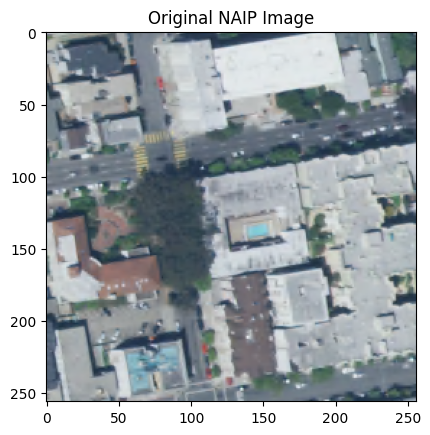

In [ ]:
plt.imshow(X_test[33]);
plt.title('Original NAIP Image');

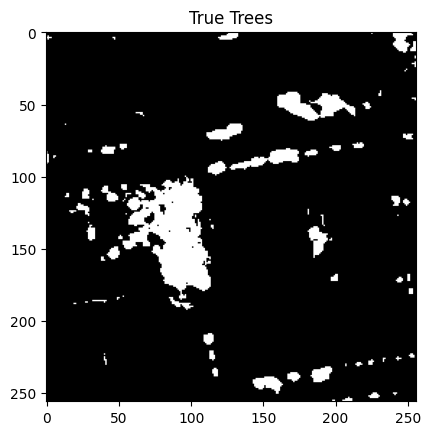

In [ ]:
plt.imshow(y_test[33], cmap='gray');
plt.title('True Trees');

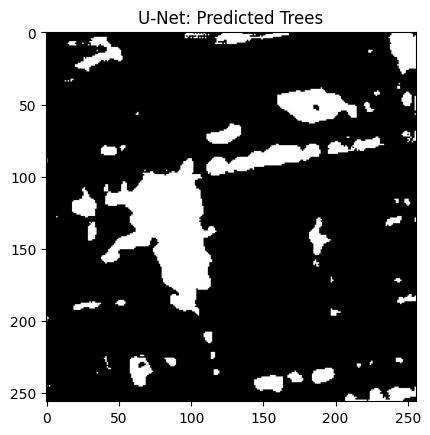

In [ ]:
plt.imshow(y_preds[33]>optimal_threshold_distance, cmap='gray');
plt.title('U-Net: Predicted Trees');